# 시간(hour)에 따른 변수들의 변화

In [9]:
# 필요모듈 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from my_function import scatter_plot_by_hour
from my_function import reg_scatter
from my_function import reg_summary
from my_function import residual_qqplot
from my_function import residual_scatter
from my_function import to_hour_category
from my_function import ANOVA
from my_function import two_sample_test
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
# 변수 전체출력
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.5f}'.format

# 시간의 정보를 시간대(아침, 점심, 저녁, 새벽)으로 나누는 함수
# 임의로 만든 기준 (두바이의 생활데이터를 기반으로)
# 4시부터 12시 "morning_time"
# 12시부터 19시 "afternoon"
# 19시부터 23시 "evening"
# 나머지 시간대 "bedtime"

# 일반적인 기준
# 6시부터 12시 "morning_time"
# 12시부터 18시 "afternoon"
# 18시부터 21시 "evening"
# 나머지 시간대 "bedtime"

# 데이터 불러오기
df = pd.read_pickle("../../data/groupby_time_data.pkl")

# 카테고리의 모음
temp_df = df.groupby(["month"]).mean().iloc[:,11:22].T.reset_index()
temp_df["index"] = temp_df["index"].apply(lambda x : x.split("_")[-1])
list_of_category_code = temp_df["index"].to_list() 

# 1차 카테고리의 모음
temp_df = df.groupby(["month"]).mean().iloc[:,33:46].T.reset_index()
temp_df["index"] = temp_df["index"].apply(lambda x : x.split("_")[-1])
list_of_category_code_0 = temp_df["index"].to_list() 

df.head()

,general_time_category,specific_time_category,time,week_day,month,day,hour,event_type_view,event_type_purchase,event_type_cart,event_type_total,total_sales,no_of_total_user,no_of_cart_user,no_of_purchase_user,purchase_of_electronics.audio.headphone,purchase_of_electronics.tablet,purchase_of_apparel.shoes,purchase_of_appliances.environment.vacuum,purchase_of_electronics.clocks,purchase_of_electronics.smartphone,purchase_of_computers.notebook,purchase_of_computers.desktop,purchase_of_appliances.kitchen.refrigerators,purchase_of_electronics.video.tv,purchase_of_appliances.kitchen.washer,sales_of_electronics.audio.headphone,sales_of_electronics.tablet,sales_of_apparel.shoes,sales_of_appliances.environment.vacuum,sales_of_electronics.clocks,sales_of_electronics.smartphone,sales_of_computers.notebook,sales_of_computers.desktop,sales_of_appliances.kitchen.refrigerators,sales_of_electronics.video.tv,sales_of_appliances.kitchen.washer,purchase_of_st_electronics,purchase_of_st_appliances,purchase_of_st_computers,purchase_of_st_apparel,purchase_of_st_furniture,purchase_of_st_auto,purchase_of_st_construction,purchase_of_st_kids,purchase_of_st_accessories,purchase_of_st_sport,purchase_of_st_medicine,purchase_of_st_country_yard,purchase_of_st_stationery,sales_of_st_electronics,sales_of_st_appliances,sales_of_st_computers,sales_of_st_apparel,sales_of_st_furniture,sales_of_st_auto,sales_of_st_construction,sales_of_st_kids,sales_of_st_accessories,sales_of_st_sport,sales_of_st_medicine,sales_of_st_country_yard,sales_of_st_stationery,cart_of_electronics.audio.headphone,cart_of_electronics.tablet,cart_of_apparel.shoes,cart_of_appliances.environment.vacuum,cart_of_electronics.clocks,cart_of_electronics.smartphone,cart_of_computers.notebook,cart_of_computers.desktop,cart_of_appliances.kitchen.refrigerators,cart_of_electronics.video.tv,cart_of_appliances.kitchen.washer,cart_of_st_electronics,cart_of_st_appliances,cart_of_st_computers,cart_of_st_apparel,cart_of_st_furniture,cart_of_st_auto,cart_of_st_construction,cart_of_st_kids,cart_of_st_accessories,cart_of_st_sport,cart_of_st_medicine,cart_of_st_country_yard,cart_of_st_stationery,view_of_electronics.audio.headphone,view_of_electronics.tablet,view_of_apparel.shoes,view_of_appliances.environment.vacuum,view_of_electronics.clocks,view_of_electronics.smartphone,view_of_computers.notebook,view_of_computers.desktop,view_of_appliances.kitchen.refrigerators,view_of_electronics.video.tv,view_of_appliances.kitchen.washer,view_of_st_electronics,view_of_st_appliances,view_of_st_computers,view_of_st_apparel,view_of_st_furniture,view_of_st_auto,view_of_st_construction,view_of_st_kids,view_of_st_accessories,view_of_st_sport,view_of_st_medicine,view_of_st_country_yard,view_of_st_stationery,no_of_view_to_purchase_user,no_of_view_to_cart_user,no_of_cart_to_purchase_user
0,bedtime,morning,2019-10-01 04:00:00,1,10,1,4,1070,10,3,1083,2387.84000,383,3.00000,9.00000,3.00000,0.00000,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,523.45000,0.00000,0.00000,0.00000,0.00000,1752.43000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2275.88000,28.03000,0.00000,0.00000,54.42000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,32,6,11,15,20,301,31,23,22.00000,12,26,379,156,60,27,26,9,17,4.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.02350,0.00783,3.00000
1,bedtime,morning,2019-10-01 05:00:00,1,10,1,5,121,0,0,121,0.00000,102,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00

In [10]:
# 시간에 따른 매출액의 변화
temp_df = df.groupby(["month", "day"]).mean()
temp_df = pd.concat([temp_df["total_sales"], temp_df.iloc[:,21:32]],axis=1)
temp_df.reset_index(inplace=True)
temp_df["time"] = list(zip(temp_df["month"], temp_df["day"]))
temp_df["time"] = temp_df["time"].apply(lambda x : f"{x[0]}월 {x[1]}일")
columns = temp_df.columns.to_list()
columns.insert(0, columns.pop())
columns.remove("month")
columns.remove("day")
temp_df = temp_df[columns]
temp_df = temp_df.set_index("time")
fig = go.Figure()
for category in temp_df.columns:
    fig.add_trace(go.Scatter(y=temp_df[category],
                            x=temp_df.index,
                            mode='lines+markers', 
                            name=f"{category.split('_')[-1]}"))                                                                                 
fig.update_layout(
    autosize=False,
    title = "일별 시간당 매출액",
    width=900,
    height=450,)
fig.show()

In [11]:
# 11월 16일과 17일은 어떤 행사나 다른 요인이 있을것으로 추정됨 분석에서 제거
drop_index = df[(df["month"] == 11) & (df["day"] == 16)].index
df = df.drop(drop_index)
df = df.reset_index(drop=True)
drop_index = df[(df["month"] == 11) & (df["day"] == 17)].index
df = df.drop(drop_index)
df = df.reset_index(drop=True)

# 제거후 다시 시각화
temp_df = df.groupby(["month", "day"]).mean()
temp_df = pd.concat([temp_df["total_sales"], temp_df.iloc[:,21:32]],axis=1)
temp_df.reset_index(inplace=True)
temp_df["time"] = list(zip(temp_df["month"], temp_df["day"]))
temp_df["time"] = temp_df["time"].apply(lambda x : f"{x[0]}월 {x[1]}일")
columns = temp_df.columns.to_list()
columns.insert(0, columns.pop())
columns.remove("month")
columns.remove("day")
temp_df = temp_df[columns]
temp_df = temp_df.set_index("time")
fig = go.Figure()
for category in temp_df.columns:
    fig.add_trace(go.Scatter(y=temp_df[category],
                            x=temp_df.index,
                            mode='lines+markers', 
                            name=f"{category.split('_')[-1]}"))                                                                                 
fig.update_layout(
    autosize=False,
    title = "일별 시간당 매출액",
    width=900,
    height=450,)
fig.show()

## 주요지표별로 월, 시간 등등 다양하게 접근
### 시간당, 접속유저수, 접속대비결제유저의 비율, 매출액, 결제횟수

### 시간당 접속유저수의 평균은 시간에 따라 차이가 있는가?

month에 따른 no_of_total_user의 평균차


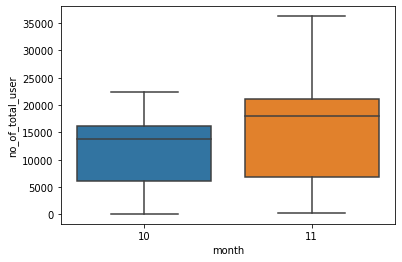

사용한 가설검정 : 독립표본 T 검정 이분산
유의확률 = 3.341703572299305e-18


3.341703572299305e-18

In [12]:
# 월별로 두 집단의 위치모수 검정
target = "no_of_total_user"
two_sample_test("month", target, df, "two-sided", 1)

# 월에 따라 시간당 접속유저수의 평균의 차이가 있다

                            OLS Regression Results                            
Dep. Variable:       no_of_total_user   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 0.0001290
Date:                Fri, 20 May 2022   Prob (F-statistic):              0.991
Time:                        17:01:08   Log-Likelihood:                -14296.
No. Observations:                1388   AIC:                         2.860e+04
Df Residuals:                    1386   BIC:                         2.861e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.303e+04    389.863     33.416      0.0

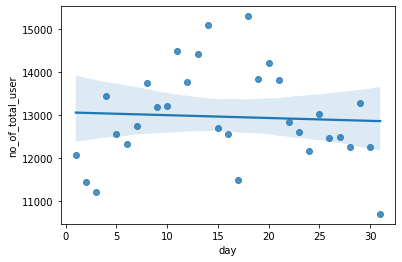

In [13]:
# 날자별로 산점도 추세확인
df["time_days"] = df["time"].apply(lambda x : (x - df["time"][0]).days)
temp_df = df.groupby("day").mean()
sns.regplot(y=temp_df[target], x=temp_df.index)
model = sm.OLS.from_formula(target + "~" + "day", data = df)
result = model.fit()
print(result.summary())

# 날자에 따라 시간당 평균 접속 유저수는 선형적인 추세가 나타나지 않는다

specific_time_category에 따른 no_of_total_user의 평균차


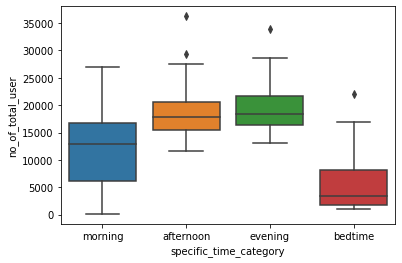

정규성 확인완료 등분산검정 실시
이분산이 나타난다 welch anova 실시
유의확률 = 4.5323096897551695e-207 분산분석의 귀무가설 기각, 다중비교 실시
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1   group2   meandiff  p-adj    lower       upper    reject
------------------------------------------------------------------
afternoon bedtime -12953.7066  0.001 -13871.221 -12036.1922   True
afternoon evening    979.1322 0.1185  -155.3583   2113.6226  False
afternoon morning  -6467.2435  0.001 -7318.1114  -5616.3757   True
  bedtime evening  13932.8388  0.001 12768.0813  15097.5963   True
  bedtime morning   6486.4631  0.001   5595.639   7377.2872   True
  evening morning  -7446.3757  0.001 -8559.3912  -6333.3602   True
------------------------------------------------------------------


In [14]:
# 시간대별로 분산분석
ANOVA("specific_time_category", target, df, 1, 0)

# 시간대에 따라 시간당 접속 유저수의 평균은 모두 같지는 않다
# afternoon 과 evening 은 다르지 않다

hour에 따른 no_of_total_user의 평균차


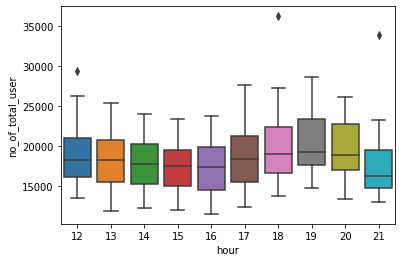

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 5.849528650402992e-10 분산분석의 귀무가설 기각, 다중비교 실시
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
    12     13  -474.3448    0.9 -2489.8969  1541.2072  False
    12     14  -998.8276 0.8459 -3014.3796  1016.7244  False
    12     15 -1533.6552 0.3177 -3549.2072   481.8969  False
    12     16 -1637.1379 0.2297   -3652.69   378.4141  False
    12     17  -290.2586    0.9 -2305.8106  1725.2934  False
    12     18  1220.7241  0.632  -794.8279  3236.2762  False
    12     19  1716.4483 0.1744  -299.1038  3732.0003  False
    12     20   995.6034  0.849 -1019.9486  3011.1555  False
    12     21 -1366.1552 0.4915 -3381.7072   649.3969  False
    13     14  -524.4828    0.9 -2540.0348  1491.0693  False
    13     15 -1059.3103 0.7876 -3074.8624   956.2417  False
    13     16 -1162.7931 0.6878 -3178.3451   852.7589  Fals

In [15]:
# 시간별로 분산분석
# 유의하지 않은 afternoon 과 evening만 확인하도록한다
ANOVA("hour", target, df[(df["specific_time_category"] == "afternoon") | (df["specific_time_category"] == "evening")], 1, 0)

# 시간에 따라 시간당 접속 유저수의 평균은 모두 같지는 않다
# 17, 18, 19, 20 시는 서로 다르지 않다.
# 17시 ~ 20시가 접속 유저수가 가장 많다.

week_day에 따른 no_of_total_user의 평균차


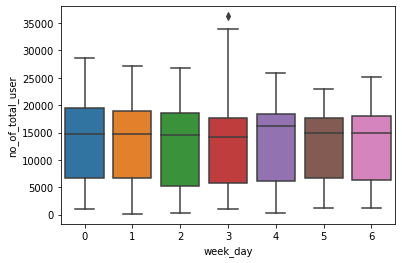

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 0.8294899254756609분산분석의 귀무가설 기각불가능, week_day별로 평균의 차이가 없다


In [16]:
# 요일로 분산분석
ANOVA("week_day", target, df, 0, 0)

# 요일별로 시간당 접속유저수의 평균은 모두 같다.

### 시간에 따라 시간당 접속유저수 대비 결제유저수의 비율의 평균은 차이가 있는가

month에 따른 no_of_view_to_purchase_user의 평균차


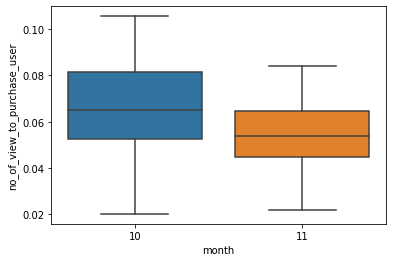

사용한 가설검정 : 독립표본 T 검정 이분산
유의확률 = 8.541031887675267e-46


8.541031887675267e-46

In [17]:
# 월별로 두 집단의 위치모수 검정
target = "no_of_view_to_purchase_user"
two_sample_test("month", target, df, "two-sided", 1)

# 월에 따라 시간당 접속유저수 대비 결제유저수의 비율의 평균의 차이가 있다.

                                 OLS Regression Results                                
Dep. Variable:     no_of_view_to_purchase_user   R-squared:                       0.001
Model:                                     OLS   Adj. R-squared:                  0.000
Method:                          Least Squares   F-statistic:                     1.201
Date:                         Fri, 20 May 2022   Prob (F-statistic):              0.273
Time:                                 17:01:10   Log-Likelihood:                 3689.7
No. Observations:                         1388   AIC:                            -7375.
Df Residuals:                             1386   BIC:                            -7365.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

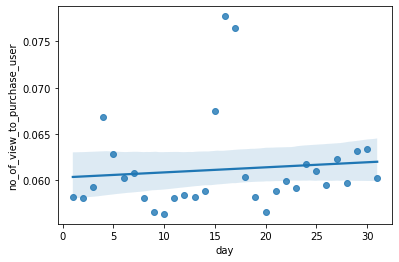

In [18]:
# 날자별로 산점도 추세확인
temp_df = df.groupby("day").mean()
sns.regplot(y=temp_df[target], x=temp_df.index)
model = sm.OLS.from_formula(target + "~" + "day", data = df)
result = model.fit()
print(result.summary())

# 날자에 따라 시간당 접속유저수 대비 결제유저수의 비율의 평균은 선형적인 추세가 나타나지 않는다

specific_time_category에 따른 no_of_view_to_purchase_user의 평균차


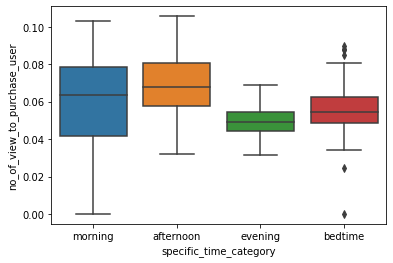

정규성 확인완료 등분산검정 실시
이분산이 나타난다 welch anova 실시
유의확률 = 4.830275314495226e-83 분산분석의 귀무가설 기각, 다중비교 실시
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj  lower   upper  reject
-------------------------------------------------------
afternoon bedtime  -0.0134 0.001 -0.0164 -0.0105   True
afternoon evening  -0.0201 0.001 -0.0237 -0.0164   True
afternoon morning  -0.0083 0.001 -0.0111 -0.0056   True
  bedtime evening  -0.0066 0.001 -0.0104 -0.0029   True
  bedtime morning   0.0051 0.001  0.0022  0.0079   True
  evening morning   0.0117 0.001  0.0081  0.0153   True
-------------------------------------------------------


In [19]:
# 시간대별로 분산분석
ANOVA("specific_time_category", target, df, 1, 0)

# 시간대에 따라 시간당 접속 유저수 대비 결제 유저수 비율의 평균은 모두 같지는 않다.
# 모두 다르게 나타난다

hour에 따른 no_of_view_to_purchase_user의 평균차


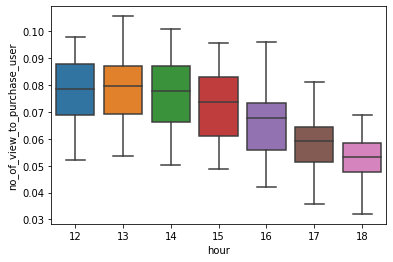

정규성 확인완료 등분산검정 실시
이분산이 나타난다 welch anova 실시
유의확률 = 4.051294869949942e-42 분산분석의 귀무가설 기각, 다중비교 실시
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    12     13   0.0008    0.9 -0.0054  0.0069  False
    12     14  -0.0014    0.9 -0.0075  0.0048  False
    12     15  -0.0052 0.1553 -0.0114  0.0009  False
    12     16  -0.0127  0.001 -0.0188 -0.0065   True
    12     17  -0.0199  0.001 -0.0261 -0.0138   True
    12     18  -0.0256  0.001 -0.0318 -0.0195   True
    13     14  -0.0021    0.9 -0.0083   0.004  False
    13     15   -0.006 0.0625 -0.0121  0.0002  False
    13     16  -0.0134  0.001 -0.0196 -0.0073   True
    13     17  -0.0207  0.001 -0.0268 -0.0145   True
    13     18  -0.0264  0.001 -0.0325 -0.0202   True
    14     15  -0.0039 0.5035   -0.01  0.0023  False
    14     16  -0.0113  0.001 -0.0175 -0.0052   True
    14     17  -0.0186  0.001 -0.0247 -0.0124   True
    

In [20]:
# 시간별로 분산분석
# 유의미하게 가장 높게 나타난 afternoon만 확인하도록한다
ANOVA("hour", target, df[df["specific_time_category"] == "afternoon"], 1, 0)
 
# 시간에 따라 시간당 접속 유저수 대비 결제 유저수의 비율의 평균은 모두 같지는 않다
# 12, 13, 14, 15 시는 서로 다르지 않다.
# 12, 13, 14, 15 시가 시간당 접속 유저수 대비 결제 유저수의 비율의 평균이 유의미하게 다르다.

week_day에 따른 no_of_view_to_purchase_user의 평균차


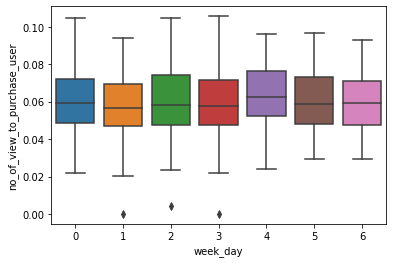

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 0.08663684126482003분산분석의 귀무가설 기각불가능, week_day별로 평균의 차이가 없다


In [21]:
# 요일로 분산분석
ANOVA("week_day", target, df, 0, 0)

# 요일별로 시간당 접속유저수 대비 결제 유저수의 비율의 평균은 모두 같다.

### 시간에 따라 시간당 매출액의 평균은 차이가 있는가?

month에 따른 total_sales의 평균차


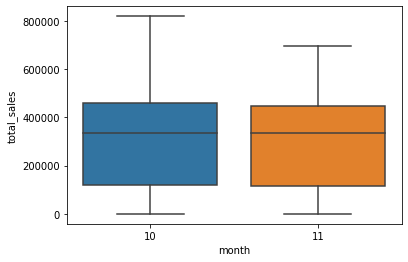

사용한 가설검정 : 독립표본 T 검정 등분산
유의확률 = 0.27491688579477536


0.27491688579477536

In [22]:
# 월별로 두 집단의 위치모수 검정
target = "total_sales"
two_sample_test("month", target, df, "two-sided", 1)

# 월에 따라 시간당 매출액의 평균은 차이가 없다.

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4174
Date:                Fri, 20 May 2022   Prob (F-statistic):              0.518
Time:                        17:01:12   Log-Likelihood:                -18788.
No. Observations:                1388   AIC:                         3.758e+04
Df Residuals:                    1386   BIC:                         3.759e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.998e+05   9916.353     30.237      0.0

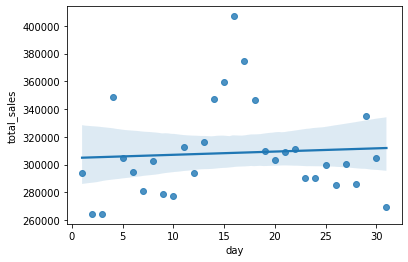

In [23]:
# 날자별로 산점도 추세확인
temp_df = df.groupby("day").mean()
sns.regplot(y=temp_df[target], x=temp_df.index)
model = sm.OLS.from_formula(target + "~" + "day", data = df)
result = model.fit()
print(result.summary())

# 날자에 따라 시간당 매출액의 평균은 선형적인 추세가 나타나지 않는다.

specific_time_category에 따른 total_sales의 평균차


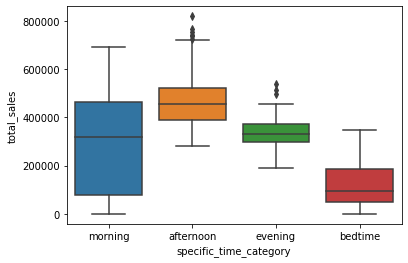

정규성 확인완료 등분산검정 실시
이분산이 나타난다 welch anova 실시
유의확률 = 2.2416039986610422e-247 분산분석의 귀무가설 기각, 다중비교 실시
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1   group2   meandiff   p-adj    lower        upper     reject
---------------------------------------------------------------------
afternoon bedtime -344284.0483 0.001  -369145.093 -319423.0035   True
afternoon evening -127787.2757 0.001 -158527.5216  -97047.0298   True
afternoon morning -178499.3561 0.001 -201554.5405 -155444.1717   True
  bedtime evening  216496.7725 0.001  184936.4076  248057.1374   True
  bedtime morning  165784.6921 0.001  141646.8496  189922.5347   True
  evening morning  -50712.0804 0.001  -80870.4394  -20553.7214   True
---------------------------------------------------------------------


In [24]:
# 시간대별로 분산분석
ANOVA("specific_time_category", target, df, 1, 0)

# 시간대에 따라 시간당 매출액의 평균은 모두 같지는 않다.
# 모두 다르게 나타난다

hour에 따른 total_sales의 평균차


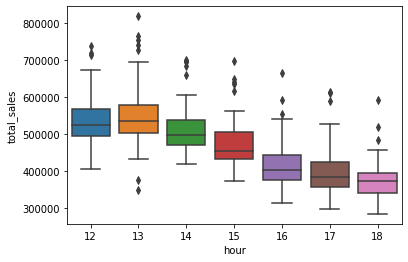

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 5.061803339468483e-52 분산분석의 귀무가설 기각, 다중비교 실시
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------
    12     13   11733.2566    0.9  -26817.1165   50283.6296  False
    12     14  -22568.3786 0.5799  -61118.7517   15981.9944  False
    12     15  -62419.4831  0.001 -100969.8562    -23869.11   True
    12     16 -121848.2426  0.001 -160398.6157  -83297.8695   True
    12     17 -140822.7445  0.001 -179373.1175 -102272.3714   True
    12     18 -161171.5981  0.001 -199721.9712  -122621.225   True
    13     14  -34301.6352 0.1181  -72852.0082    4248.7379  False
    13     15  -74152.7397  0.001 -112703.1127  -35602.3666   True
    13     16 -133581.4991  0.001 -172131.8722  -95031.1261   True
    13     17  -152556.001  0.001 -191106.3741  -114005.628   True
    13     18 -172904.8547  0.001 -211455.

In [25]:
# 시간별로 분산분석
# 유의미하게 가장 높게 나타난 afternoon만 확인하도록한다
ANOVA("hour", target, df[df["specific_time_category"] == "afternoon"], 1, 0)

# 시간에 따라 시간당 매출액의 평균은 모두 같지는 않다
# 12, 13, 14시는 서로 다르지 않다.

week_day에 따른 total_sales의 평균차


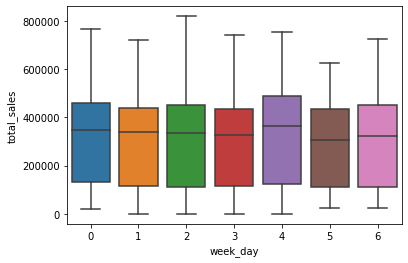

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 0.3992234009355892분산분석의 귀무가설 기각불가능, week_day별로 평균의 차이가 없다


In [26]:
# 요일로 분산분석
ANOVA("week_day", target, df, 0, 0)
# 요일별로 시간당 매출액의 평균은 모두 같다.

### 시간에 따라 시간당 결제횟수의 평균은 차이가 있는가?

month에 따른 event_type_purchase의 평균차


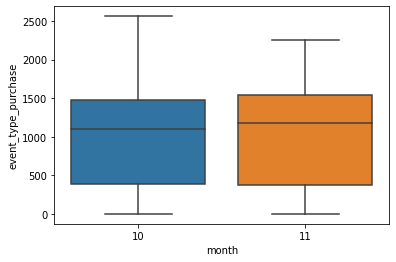

사용한 가설검정 : 독립표본 T 검정 등분산
유의확률 = 0.5067757328877256


0.5067757328877256

In [27]:
# 월별로 두 집단의 위치모수 검정
target = "event_type_purchase"
two_sample_test("month", target, df, "two-sided", 1)

# 월에 따라 시간당 결제 횟수의 평균은 차이가 없다.

                             OLS Regression Results                            
Dep. Variable:     event_type_purchase   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.7653
Date:                 Fri, 20 May 2022   Prob (F-statistic):              0.382
Time:                         17:01:13   Log-Likelihood:                -10876.
No. Observations:                 1388   AIC:                         2.176e+04
Df Residuals:                     1386   BIC:                         2.177e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    988.0257     33.164     29.79

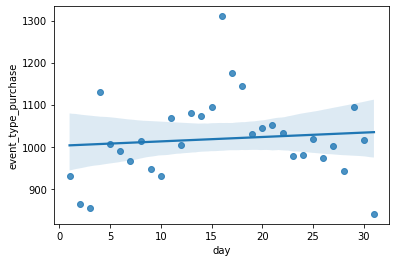

In [28]:
# 날자별로 산점도 추세확인
temp_df = df.groupby("day").mean()
sns.regplot(y=temp_df[target], x=temp_df.index)
model = sm.OLS.from_formula(target + "~" + "day", data = df)
result = model.fit()
print(result.summary())

# 날자에 따라 시간당 결제횟수 평균은 선형적인 추세가 나타나지 않는다

specific_time_category에 따른 event_type_purchase의 평균차


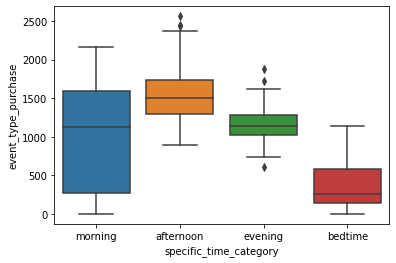

정규성 확인완료 등분산검정 실시
이분산이 나타난다 welch anova 실시
유의확률 = 3.734405371363365e-265 분산분석의 귀무가설 기각, 다중비교 실시
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1   group2  meandiff  p-adj   lower      upper    reject
---------------------------------------------------------------
afternoon bedtime -1164.2257 0.001 -1246.4812 -1081.9701   True
afternoon evening  -370.3268 0.001  -472.0343  -268.6193   True
afternoon morning  -537.9554 0.001   -614.236  -461.6747   True
  bedtime evening   793.8989 0.001   689.4779   898.3199   True
  bedtime morning   626.2703 0.001   546.4076    706.133   True
  evening morning  -167.6286 0.001  -267.4109   -67.8463   True
---------------------------------------------------------------


In [29]:
# 시간대별로 분산분석
ANOVA("specific_time_category", target, df, 1, 0)

# 시간대에 따라 시간당 결제횟수의 평균은 모두 같지는 않다.
# 모두 다르게 나타난다

hour에 따른 event_type_purchase의 평균차


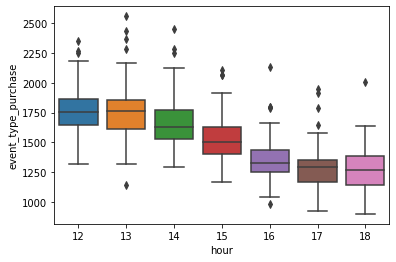

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 3.6711129219156875e-53 분산분석의 귀무가설 기각, 다중비교 실시
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
    12     13   -0.0517    0.9 -120.4009  120.2975  False
    12     14 -104.5862 0.1361 -224.9354    15.763  False
    12     15 -248.2069  0.001 -368.5561 -127.8577   True
    12     16 -424.3966  0.001 -544.7457 -304.0474   True
    12     17 -482.9138  0.001  -603.263 -362.5646   True
    12     18 -512.6207  0.001 -632.9699 -392.2715   True
    13     14 -104.5345 0.1365 -224.8837   15.8147  False
    13     15 -248.1552  0.001 -368.5044  -127.806   True
    13     16 -424.3448  0.001  -544.694 -303.9956   True
    13     17 -482.8621  0.001 -603.2112 -362.5129   True
    13     18  -512.569  0.001 -632.9181 -392.2198   True
    14     15 -143.6207 0.0082 -263.9699  -23.2715   True
    14     16 -319.8103  0.001 -440.1595 -

In [30]:
# 시간별로 분산분석
# 유의미하게 가장 높게 나타난 afternoon만 확인하도록한다
ANOVA("hour", target, df[df["specific_time_category"] == "afternoon"], 1, 0)

# 시간에 따라 시간당 결제횟수 평균은 모두 같지는 않다
# 12, 13, 14시는 서로 다르지 않다.

week_day에 따른 event_type_purchase의 평균차


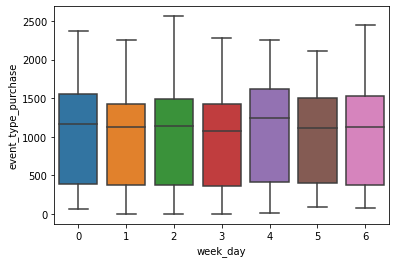

정규성 확인완료 등분산검정 실시
등분산 확인완료 분산분석 실시
유의확률 = 0.593068993377702분산분석의 귀무가설 기각불가능, week_day별로 평균의 차이가 없다


In [31]:
# 요일로 분산분석
ANOVA("week_day", target, df, 0, 0)
# 요일별로 시간당 결제횟수의 평균은 모두 같다.

### 가설검정의 결론
1. 월(month)에 따라 시간당 접속 유저수의 평균은 다르다.  
2. 날자에 따라 시간당 접속 유저수의 평균은 선형적인 추세가 나타나지 않는다.  
3. 시간대에 따라 시간당 접속 유저수의 평균은 모두 같지는 않다. (afternoon과 evening은 같다)  
4. 시간(hour)에 따라 시간당 접속 유저수의 평균은 모두 같지는 않다.(17~20시는 같다.)  
5. 요일에 따라 시간당 접속유저수의 평균은 모두 같다.  

1. 월(month)에 따라 시간당 접속유저수 대비 결제유저수의 비율의 평균은 다르다.  
2. 날자에 따라 시간당 접속유저수 대비 결제유저수의 비율의 평균은 선형적인 추세가 나타나지 않는다.  
3. 시간대에 따라 시간당 접속 유저수 대비 결제 유저수 비율의 평균은 모두 같지는 않다.  
4. 시간(hour)에 따라 시간당 접속 유저수 대비 결제 유저수의 비율의 평균은 모두 같지는 않다(12 ~ 15시는 같다)  
5. 요일에 따라 시간당 접속 유저수 대비 결제 유저수의 비율의 평균은 모두 같다.  

1. 월(month)에 따라 시간당 매출액의 평균은 같다.  
2. 날자에 따라 시간당 매출액의 평균은 선형적인 추세가 나타나지 않는다.  
3. 시간대에 따라 시간당 매출액의 평균은 모두 같지는 않다.  
4. 시간(hour)에 따라 시간당 매출액 평균은 모두 같지는 않다.(12~14시는 같다.)  
5. 요일에 따라 시간당 매출액 평균은 모두 같다.  

1. 월(month)에 따라 시간당 결제횟수의 평균은 같다.  
2. 날자에 따라 시간당 결제횟수 평균은 선형적인 추세가 나타나지 않는다.  
3. 시간대에 따라 시간당 결제횟수 평균은 모두 같지는 않다.  
4. 시간(hour)에 따라 시간당 결제횟수의 평균은 모두 같지는 않다.(12~14시는 같다.)  
5. 요일에 따라 시간당 결제횟수의 평균은 모두 같다.  